# Categorical Boost
#### cv score :  0.5639017013232513 (5 folds, LB 0.5609)
#### cv score :  0.5639017013232513 (5 folds, find rare, LB )
#### cv score :  0.571281663516068 ... (LB 0.555) onehotなし、

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro
import warnings
warnings.filterwarnings('ignore')

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
from catboost import Pool, CatBoostClassifier, CatBoost
import matplotlib.pyplot as plt
import seaborn as sns


FEATURE_SELECTION = False
tgt_encode = False

random.seed(0)

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

%matplotlib inline

In [2]:
train_df = pd.read_csv("../../data/Processed/train2.csv")
test_df = pd.read_csv("../../data/Processed/test2.csv")
print(train_df.shape)
print(test_df.shape)

(66125, 304)
(28340, 303)


In [3]:
y = train_df["y"].values
train_df = train_df.drop("y", axis=1)

In [4]:
# add disconnection info

train_df = prepro.add_disconnection(train_df)
test_df = prepro.add_disconnection(test_df)

In [5]:
# add info about numeric column
# 武器データの中のnum_colsを持つ特徴について、チーム内の統計量を計算、levelは結構効いてる

# num_cols = ["level", "range", "rapid", "atack", "ink-sub", "fav-main", "good-special"]

num_cols = [
    "level", "range-main", "range-bullet-main", "distant-range_sub", 
    "rapid", "atack", "ink-sub", "fav-main", "good-special", "DPS", "kill_time_ika-main",
    "front_gap_human-main", "rensya_frame-main", "saidai_damege-main", "damage_min-sub", 
    "damage_max-sub", "install_num-sub", "good-sub", "damage_max-special", 
    "duration-special", "good-special", "direct_rad-special", "distant_rad-special"
]

cols = [col for col in train_df.columns if "A1" in col or "A2" in col or "A3" in col or "A4" in col or 
        "B1" in col or "B2" in col or "B3" in col or "B4" in col]
drop_cols = []
for col1 in cols:
    f = True
    for col2 in num_cols:
        if col2 in col1:
            f = False
    if f and train_df[col1].dtype in [int, float]:
        drop_cols.append(col1)
        
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)
        
    

train_df = prepro.add_numeric_info(train_df, num_cols)
test_df = prepro.add_numeric_info(test_df, num_cols)



In [6]:
#train_df

# 欠損値埋め先にやろう
欠損値がある列

rank, weapon, level ⇨　回線切れ or ナワバリ

weaponの欠損に並んでそれに関係ある列、A3, A4, B3, B4 ⇨ 回線切れ

level, weaponが消えていたら回線切れ

In [7]:
# rankの欠損値を埋める
train_df, test_df = prepro.fillna_rank(train_df, test_df)

#そのほかの欠損値を埋める
train_df, test_df = prepro.fillna(train_df, test_df)

In [8]:
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


# 特徴量エンジニアリング

In [9]:
# count reskin, by mode
print("reskin")
train_df, test_df = prepro.count_reskin(train_df, test_df)
train_df, test_df = prepro.count_reskin_by_mode(train_df, test_df)

# count mainweapon, by mode
print("mainweapon")
train_df, test_df = prepro.count_mainweapon(train_df, test_df)
train_df, test_df = prepro.count_mainweapon_by_mode(train_df, test_df)

# count subweapon, by mode
print("subweapon")
train_df, test_df = prepro.count_subweapon(train_df, test_df)
train_df, test_df = prepro.count_subweapon_by_mode(train_df, test_df)

# count special, by mode
print("special")
train_df, test_df = prepro.count_special(train_df, test_df)
train_df, test_df = prepro.count_special_by_mode(train_df, test_df)


#identify A1
train_df, test_df = prepro.identify_A1(train_df, test_df)


# 水増し, A1も統計量に含めた特徴を作る場合は水ましより先にやる
print("mizumashi")
train_df, y = prepro.mizumashi(train_df, y)

# is_nawabari
train_df, test_df = prepro.is_nawabari(train_df, test_df)

# match rank、単体で意味なし
train_df, test_df = prepro.match_rank(train_df, test_df)

# rankを二列に分ける
train_df, test_df = prepro.ranker(train_df, test_df)




reskin
mainweapon
subweapon
special
mizumashi


'train_df["level-mean-sub"] = train_df["A-level-mean"] - train_df["B-level-mean"]\ntrain_df["level-mean-div"] = train_df["A-level-mean"] / train_df["B-level-mean"]\ntrain_df["level-median-sub"] = train_df["A-level-median"] - train_df["B-level-median"]\ntrain_df["level-median-div"] = train_df["A-level-median"] / train_df["B-level-median"]\ntest_df["level-mean-sub"] = test_df["A-level-mean"] - test_df["B-level-mean"]\ntest_df["level-mean-div"] = test_df["A-level-mean"] / test_df["B-level-mean"]\ntest_df["level-median-sub"] = test_df["A-level-median"] - test_df["B-level-median"]\ntest_df["level-median-div"] = test_df["A-level-median"] / test_df["B-level-median"]'

In [10]:
# add team info、メインはなくてもいい

train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "mainweapon"])
#train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2"])

(160590, 588)
special-A
special-B
subweapon-A
subweapon-B
category1-A
category1-B
category2-A
category2-B
mainweapon-A
mainweapon-B
(160590, 782)
complete


In [11]:
# categorize team , 良い, メインはカテゴリ数が多すぎてやめた方がいい

categorize_col = ["category1", "category2", "subweapon", "special", "mainweapon"]
#categorize_col = ["category1", "category2", "subweapon", "special"]
for col in categorize_col:
    print(col)
    train_df, test_df = prepro.categorize_team(train_df, test_df, col)

category1
category2
subweapon
special


In [12]:
# レアなカテゴリをまとめる、しない方が上がった…

#train_df, test_df = prepro.find_rare(train_df, test_df, "team-category1")
#train_df, test_df = prepro.find_rare(train_df, test_df, "team-category2")
#train_df, test_df = prepro.find_rare(train_df, test_df, "team-subweapon")
#train_df, test_df = prepro.find_rare(train_df, test_df, "team-special")

fin count
fin find rare 47
fin count
fin find rare 216
fin count
fin find rare 469
fin count
fin find rare 1112


In [13]:
# product categorical feature
train_df, test_df = prepro.prod(train_df, test_df, "mode", "stage")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "match_rank")

train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "match_rank")


train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A4")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B4")

In [14]:
"""#one hot 落とす
drop_cols = [col for col in train_df.columns if "onehot" in col]
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)"""

'#one hot 落とす\ndrop_cols = [col for col in train_df.columns if "onehot" in col]\ntrain_df.drop(columns=drop_cols, inplace=True)\ntest_df.drop(columns=drop_cols, inplace=True)'

In [15]:
# make input

drop_cols = ["id", "lobby", "lobby-mode",  "period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", \
              "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]

X, test_X = prepro.make_input(train_df, test_df, drop_cols, categorical_encode=False, scaler=False, verbose=False)

categorical_features_indices = np.where(X.dtypes == "object")[0]

complete


# 学習

In [16]:
# 全データを5つに分割
random.seed(random.randint(0, 10000))
SIZE = X.shape[0]
K = 5
cat_tgtenc_cols = [
    "team-category1-A", "team-category1-B", "team-category2-A", "team-category2-B",
    "team-subweapon-A", "team-subweapon-B", "team-special-A", "team-special-B"
]
cat_tgtenc_cols = []

#folds = prepro.make_stratified_kfolds(X, y, K, shuffle=True)
folds = prepro.make_stratified_kfolds(X, X["mode"].astype(str) + y.astype(str), K, shuffle=True, random_state=random.randint(0, 10000))


print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    
    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")

5
fold  1  size is  26450
fold  2  size is  26450
fold  3  size is  26450
fold  4  size is  26450
fold  5  size is  26450
successfully split


In [17]:
params = {
    "loss_function" : "Logloss",
    "eval_metric" : "Logloss",
    "iterations":2000,
    "learning_rate" : 0.05,
    "use_best_model": True,
    "random_seed":random.randint(0, 100000),

    

}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []
valid_ys = []

all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    

    train_X = X.iloc[train_indices]
    try:
        train_y = y.iloc[train_indices]
    except:
        train_y = y[train_indices]
    valid_X = X.iloc[valid_indices]
    try:
        valid_y = y.iloc[valid_indices]
    except:
        valid_y = y[valid_indices]
    
    
    
    
    train_data = Pool(train_X, train_y, cat_features=categorical_features_indices)
    valid_data = Pool(valid_X, valid_y, cat_features=categorical_features_indices)
    
    model = CatBoostClassifier(**params)

    
    model.fit(
        train_data,
        eval_set=valid_data,
        early_stopping_rounds=50,
        verbose=100,
        use_best_model=True,
    )
    
    pred = model.predict(valid_X, prediction_type='Probability')[:,1]
    train_pred.append(pred)
    pred = np.where(pred < THRESHOLD, 0, 1)

    temp += np.sum(pred) 
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 1 ========================
0:	learn: 0.6927101	test: 0.6927791	best: 0.6927791 (0)	total: 889ms	remaining: 29m 37s
100:	learn: 0.6809059	test: 0.6845057	best: 0.6845057 (100)	total: 1m 26s	remaining: 26m 57s
200:	learn: 0.6755962	test: 0.6823644	best: 0.6823644 (200)	total: 3m 12s	remaining: 28m 41s
300:	learn: 0.6697111	test: 0.6808437	best: 0.6808437 (300)	total: 4m 43s	remaining: 26m 39s
400:	learn: 0.6638612	test: 0.6794528	best: 0.6794506 (395)	total: 6m 35s	remaining: 26m 17s
500:	learn: 0.6586326	test: 0.6781681	best: 0.6781681 (500)	total: 8m 17s	remaining: 24m 48s
600:	learn: 0.6532932	test: 0.6772616	best: 0.6772594 (597)	total: 10m 7s	remaining: 23m 33s
700:	learn: 0.6486598	test: 0.6770335	best: 0.6770222 (691)	total: 11m 42s	remaining: 21m 41s
800:	learn: 0.6441365	test: 0.6765956	best: 0.6765748 (786)	total: 13m 36s	remaining: 20m 21s
900:	learn: 0.6398007	test: 0.6762495	best: 0.6762354 (892)	total: 15m 23s	remaining: 18m 46s
Stopped by over

0.5144631821832824
0.5108347210580926
0.5141122906389213
0.5119162819784262
0.5126138014546214
0.5127880554626688


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

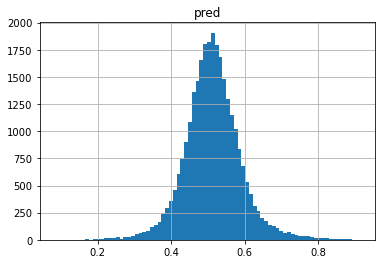

In [18]:
preds = []
for i in range(K):
    model = models[i]
    pred = model.predict(test_X, prediction_type='Probability')[:,1]
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=80)

In [19]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
submit_df.to_csv('../Submissions/submission_cat_6_{}.csv'.format(K))

0.5744530698659139


# モデル解釈

In [20]:
importance = pd.DataFrame(
    (models[0].get_feature_importance() + 
    models[1].get_feature_importance() + 
    models[2].get_feature_importance() + 
    models[3].get_feature_importance() + 
    models[4].get_feature_importance())/5
    , index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance[:120])

,importance
B-level-median,1.922398
A-level-median,1.918236
A1-level,0.966815
B1-level,0.934180
B-level-sum,0.928896
A-level-mean,0.897209
A-level-sum,0.885403
B-level-max,0.804352
A-level-min,0.794233
B-level-min,0.776264


In [21]:
indices = [index for index in importance.index if "team" in index]
importance.loc[indices]

,importance
mode x team-special-A,0.717546
stage x team-subweapon-B,0.469486
mode x team-category2-B,0.366931
mode x team-category1-B,0.364743
stage x team-category1-A,0.345622
mode x team-category1-A,0.334145
mode x team-category2-A,0.332143
team-category2-A,0.285810
stage x team-category1-B,0.285790
team-category2-B,0.255440


In [ ]:
train_pred

In [ ]:
train_df[train_df["disconnection-A"] != 0][["disconnection-A", "disconnection-B", "y", "pred"]]

In [27]:
train_df["pred"] = 0
train_df["y"] = y
for i in range(K):
    train_df["pred"].iloc[folds[i]] = np.where(train_pred[i] < THRESHOLD, 0, 1)
    #train_df["pred"].iloc[folds[i]] = train_pred[i]
for mode in train_df["mode"].unique():
    rate = train_df[train_df["mode"] == mode][train_df["pred"] == train_df["y"]].shape[0] / train_df[train_df["mode"] == mode].shape[0]
    print("{} : {}".format(mode, rate))
print(train_df[train_df["pred"] == train_df["y"]].shape[0] / train_df.shape[0])

nawabari : 0.6152727776239268
hoko : 0.5556128082443872
yagura : 0.5563174114021572
area : 0.5550735443638583
asari : 0.5469941136736466
0.5673119092627599


In [ ]:
result_df = train_df[train_df["y"] != train_df["pred"]]

In [ ]:
print(result_df[result_df["mode"] == "nawabari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "hoko"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "asari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "area"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "yagura"].shape[0]/result_df.shape[0])

In [ ]:
result_df[result_df["mode"] == "nawabari"]

In [ ]:
preds

In [22]:
def plot_feature_importance(importance,names,model_type, MAXSIZE=120):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)[:MAXSIZE]
    feature_names = np.array(names)[:MAXSIZE]

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,16))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

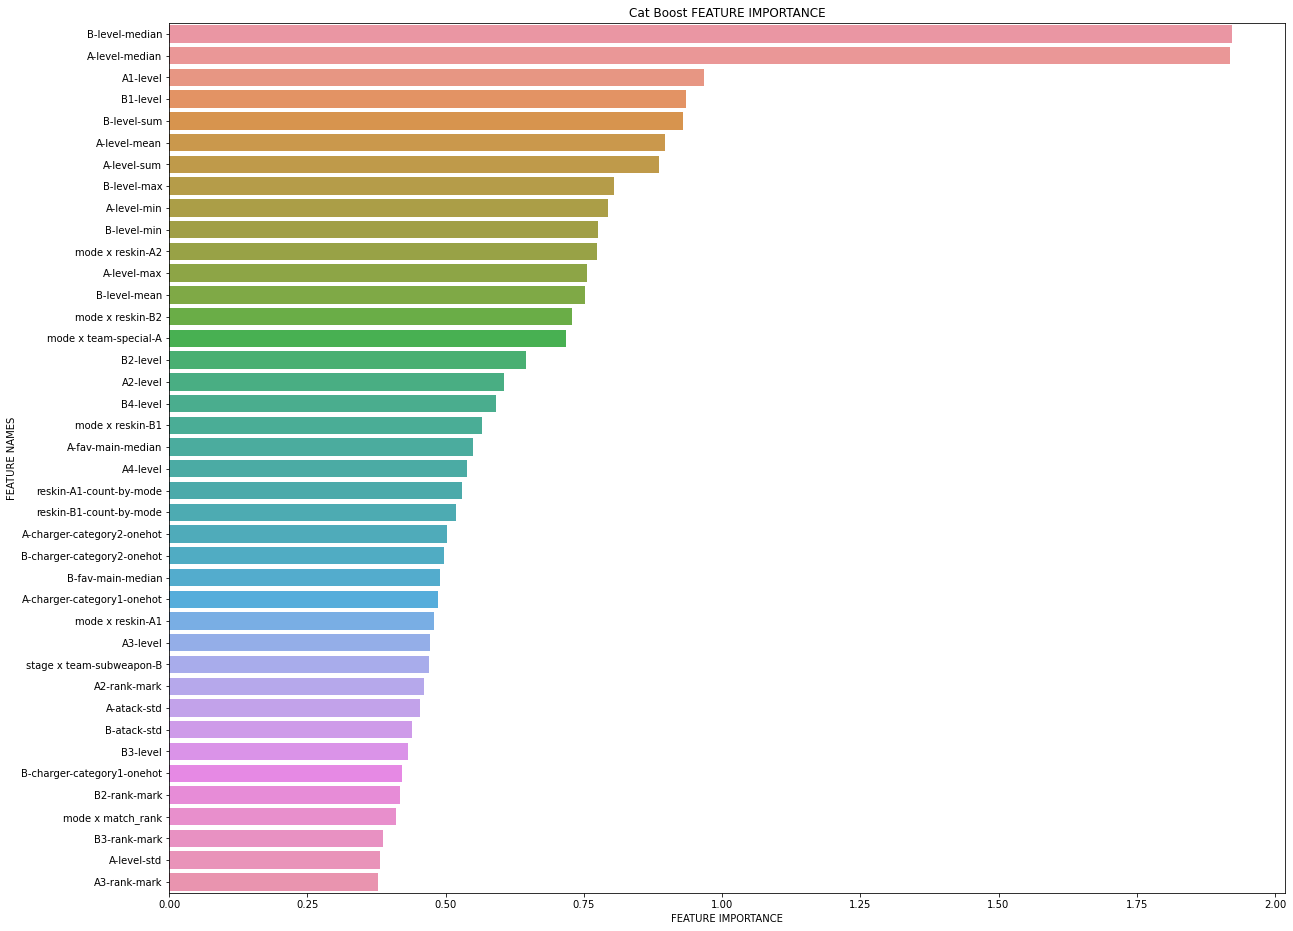

In [26]:
plot_feature_importance(importance.values.reshape(-1,), importance.index, "Cat Boost ", MAXSIZE=40)

In [ ]:
train_df

In [ ]:
v = train_df["team-subweapon-A"].value_counts().add(
    train_df["team-subweapon-B"].value_counts().add(
        test_df["team-subweapon-A"].value_counts().add(
            test_df["team-subweapon-A"].value_counts(), fill_value=0
        ), fill_value=0
    ), fill_value=0
).sort_values(ascending=False)

In [ ]:
x = np.arange(len(v))
plt.bar(x, v)
plt.show()

In [ ]:
def find_rare(df1, df2, col, threshold=4):
    v_tra = df1[col + "-A"].value_counts()
    v_trb = df1[col + "-B"].value_counts()
    v_tea = df2[col + "-A"].value_counts()
    v_teb = df2[col + "-B"].value_counts()
    
    v_counts = v_tra.add(v_trb, fill_value=0)
    v_counts = v_counts.add(v_tea, fill_value=0)
    v_counts = v_counts.add(v_teb, fill_value=0)
    
    #threshold = v_counts.iloc[int(v_counts.shape[0]*0.8)]

    tra = df1[col + "-A"].unique()
    trb = df1[col + "-B"].unique()
    tea = df2[col + "-A"].unique()
    teb = df2[col + "-B"].unique()

    not_appeared = []
    print("fin count")
    for item in v_counts.index:
        if item not in tra or item not in trb or item not in tea or item not in teb or v_tra.loc[item] < 5 or v_trb.loc[item] < 5:
            not_appeared.append(item)

    print("fin find rare", len(not_appeared))
    df1[col + "-A"] = df1[col + "-A"].map(lambda x: "rare" if x in not_appeared else x)
    df1[col + "-B"] = df1[col + "-B"].map(lambda x: "rare" if x in not_appeared else x)
    df2[col + "-A"] = df2[col + "-A"].map(lambda x: "rare" if x in not_appeared else x)
    df2[col + "-B"] = df2[col + "-B"].map(lambda x: "rare" if x in not_appeared else x)

    return df1, df2

In [ ]:
train_df, test_df = find_rare(train_df, test_df, "team-special") #473 sub

In [ ]:
test_df["team-special-A"].value_counts().sort_values(ascending=False)